<a href="https://colab.research.google.com/github/AkiraTerao/AT/blob/master/mie_func.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
disp=1
fv=0.05
lam=0.532 # um
dia=1 # um
npar=1.57 
nmed=1.33
#musgp=getMieScatter(lam,dia,fv,npar,nmed,disp)
#musgp

Vsphere = 4/3*np.pi*(dia/2)**3;     # volume of sphere
rho     = fv/Vsphere;           # #/um^3, concentration of spheres
m = npar/nmed;                  # ratio of refractive indices
x = np.pi*dia/(lam/nmed);       # ratio circumference/wavelength in medium

In [ ]:
dia_list=np.arange(0.5,10,0.1)
vsph = 4/3*np.pi*(dia_list/2)**3
rho = 1e-8
fvs = vsph*rho
num = np.size(dia_list)
result =[]
for i in np.arange(0,num):
  musgp=getMieScatter(lam,dia_list[i],fvs[i],npar,nmed,0)
  result.append(np.array([dia_list[i],musgp[0],musgp[1],musgp[2],musgp[3],musgp[4],musgp[5]]))

In [ ]:
result[0:3]

[array([5.00000000e-01, 1.84136076e-05, 8.56720534e-01, 2.63829186e-06,
        9.37797336e-01, 8.96071852e-02, 1.84136076e-01]),
 array([6.00000000e-01, 3.75371609e-05, 8.87366718e-01, 4.22793365e-06,
        1.32760549e+00, 1.82289943e-02, 3.75371609e-01]),
 array([7.00000000e-01, 6.70884354e-05, 9.04322951e-01, 6.41882355e-06,
        1.74325814e+00, 2.54251928e-02, 6.70884354e-01])]

In [ ]:

ind=np.where((dia_list>0.95) & (dia_list<1.05))

result[ind[0][0]]


array([5.00000000e-01, 1.84136076e-05, 8.56720534e-01, 2.63829186e-06,
       9.37797336e-01, 8.96071852e-02, 1.84136076e-01])

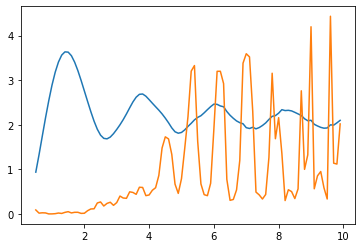

In [ ]:
re2=np.array(result)
dias=re2[:,0]
qs=re2[:,4]
qr =re2[:,5]
plt.plot(dias,qs)
plt.plot(dias,qr)

In [ ]:
values = np.arange(0.5,4,0.5)

result = values[np.where(values==2)]
print(result)
ind=np.where(np.logical_or(values>4,values==2))
values[ind]

[2.]


array([2.])

In [64]:
def getMieScatter(lam,dia,fv,npar,nmed,disp):

  Vsphere = 4/3*np.pi*(dia/2)**3;     # volume of sphere
  rho     = fv/Vsphere;           # #/um^3, concentration of spheres
  m = npar/nmed;                  # ratio of refractive indices
  x = np.pi*dia/(lam/nmed);       # ratio circumference/wavelength in medium

  u=mie(m,x)
  qsca = u[4];                    # scattering efficiency, Qsca
  g  = u[7];                    # anisotropy, g
  qratio = u[8]
  A  = np.pi*dia**2/4;          # geometrical cross-sectional area, um^2
  sigma_s = qsca*A;               # scattering cross-section, um^2
  mus     = sigma_s*rho*1e4;      # scattering coeff. cm^-1
  musp    = mus*(1-g);            # reduced scattering coeff. cm^-1
  if disp==1:
    print('----- choice:')
    print(f'lambda = {lam: .4f} um')
    print(f'diameter = {dia: .4f} um')
    print(f'rho =  {rho: .4f} 1/um^3')
    print(f'npar = {npar: .3f}')
    print(f'nmed = {nmed: .3f}')
    print('----- result:')
    print('real(m):' , u[0])
    print('imag(m):', u[1])
    print('x: ', u[2])
    print('qext: ', u[3])
    print('qsca: ', u[4])
    print('qabs: ', u[5])
    print('qb: ', u[6])
    print('asy: ', u[7])
    print('qratio: ', u[8])
    print('----- optical properties:')
    print('mus =' +str(mus)+ ' cm^-1 ')
    print('g = ',g)
    print('musp = ' +str(musp)+ 'cm^-1')
  musgp= np.real([mus, g, musp, qsca, qratio, sigma_s ]);
  return musgp

In [65]:
def mie(m,x):
  if x==0: # To avoid a singularity at x=0
    result=np.array([np.real(m),np.imag(m), 0, 0, 0, 0, 0, 0, 1.5])
  elif x>0: # This is the normal situation
    nmax=round(2+x+4*x**(1/3));
  n1=nmax-1;
  n=np.arange(1,nmax+1);cn=2*n+1; c1n=n*(n+2)/(n+1); c2n=cn/n/(n+1);
  x2=x*x;
  f=mie_abcd(m,x)
  anp=np.real(f[0,:]); anpp=np.imag(f[0,:]);
  bnp=np.real(f[1,:]); bnpp=np.imag(f[1,:]);
  g1=np.zeros([4,nmax]); g1[0,:n1]=anp[1:nmax]; g1[1,:n1]=anpp[1:nmax]; g1[2,:n1]=bnp[1:nmax]; g1[3,:n1]=bnpp[1:nmax]
  dn=cn*(anp+bnp);
  q=sum(dn);
  qext=2*q/x2;
  en=cn*(anp*anp+anpp*anpp+bnp*bnp+bnpp*bnpp);
  q=sum(en);
  qsca=2*q/x2;
  qabs=qext-qsca;
  fn=(f[0,:]-f[1,:])*cn;
  gn=(-1)**n;
  f[2,:]=fn*gn;
  q=np.sum(f[2,:]);
  qb=q*np.conjugate(q)/x2;
  asy1=c1n*(anp*g1[0,:]+anpp*g1[1,:]+bnp*g1[2,:]+bnpp*g1[3,:]);
  asy2=c2n*(anp*bnp+anpp*bnpp);
  asy=4/x2*np.sum(asy1+asy2)/qsca;
  qratio=qb/qsca;
  result2=np.array([np.real(m), np.imag(m), x, qext, qsca, qabs, qb, asy, qratio]);
  result=np.real(result2)
  return result

In [66]:
def mie_abcd(m,x):
  from scipy.special import jv, yv
  nmax=round(2+x+4*x**(1/3));
  n=np.arange(1,nmax+1); nu =(n+0.5); z=m*x; m2=m*m;
  sqx= np.sqrt(0.5*np.pi/x); sqz= np.sqrt(0.5*np.pi/z);
  bx = jv(nu, x)*sqx
  bz = jv(nu, z)*sqz
  yx = yv(nu, x)*sqx
  hx = bx+1j*yx;
  b1x=np.concatenate([[np.sin(x)/x],bx[0:nmax-1]])
  b1z=np.concatenate([[np.sin(z)/z],bz[0:nmax-1]])
  y1x=np.concatenate([[-np.cos(x)/x],yx[0:nmax-1]])
  h1x= b1x+1j*y1x;
  ax = x*b1x-n*bx;
  az = z*b1z-n*bz;
  ahx= x*h1x-n*hx;
  an = (m2*bz*ax-bx*az)/(m2*bz*ahx-hx*az);
  bn = (bz*ax-bx*az)/(bz*ahx-hx*az);
  cnf = (bx*ahx-hx*ax)/(bz*ahx-hx*az);
  dn = m*(bx*ahx-hx*ax)/(m2*bz*ahx-hx*az);
  result=np.array([an, bn, cnf, dn]);
  return result

In [67]:
def mie_pt(u,nmax):
  p=np.zeros(nmax+1);t=np.zeros(nmax+1)
  p[0]=0; p[1]=1; p[2]=3*u; 
  t[0]=0; t[1]=u; t[2]=3*np.cos(2*np.arccos(u))
  for n1 in np.arange(3,nmax+1):
    p1=(2*n1-1)/(n1-1)*p[n1-1]*u
    p2=n1/(n1-1)*p[n1-2]
    p[n1]=p1-p2
    t1=n1*u*p[n1]
    t2=(n1+1)*p[n1-1]
    t[n1]=t1-t2
  result=[p,t];
  return result
def mie_S12(m,x,u):
  nmax=round(2+x+4*x**(1/3))
  abcd=mie_abcd(m,x); 
  an=abcd[0,:] 
  bn=abcd[1,:]
  pt=mie_pt(u,nmax)
  pin = pt[0][1:]
  tin = pt[1][1:]
  n=np.arange(1,nmax+1)
  n2=(2*n+1)/(n*(n+1))
  pin=n2*pin
  tin=n2*tin
  S1=np.sum((an*pin+bn*tin)); S2=np.sum((an*tin+bn*pin))
  result=[S1,S2]
  return result

In [89]:
def mie_tetascan(m,x,nsteps):
  nsteps=nsteps
  m1=np.real(m) 
  m2=np.imag(m)
  nx = np.arange(1,nsteps+1)
  dteta=np.pi/(nsteps-1)
  teta=(nx-1)*dteta
  SL=[]
  SR=[]
  for j in np.arange(1,nsteps+1):
    u=np.cos(teta[j-1])
    a = mie_S12(m,x,u)
    SL.append(np.real(a[0]*np.conjugate(a[0])))
    SR.append(np.real(a[1]*np.conjugate(a[1])))
  y1=np.concatenate([teta,teta+np.pi])
  y2=np.concatenate([SL,SR[::-1]])
  y=[y1,y2]
  return y

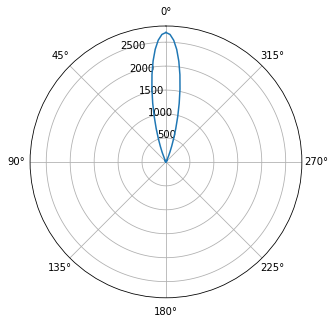

In [96]:
y0=mie_tetascan(m,x,100)
plt.figure(figsize=(10,5))
ax = plt.subplot(111, polar=True)
size = 1000

ax.plot(y0[0], y0[1])
ax.set_theta_zero_location("N") 

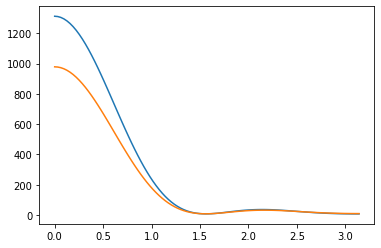

In [ ]:
plt.plot(teta,SL)
plt.plot(teta,SR)

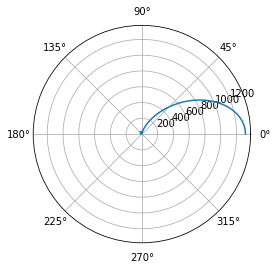

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(teta, SL)

In [ ]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])